# Write a Machine Learning Algorithm to predict currency price for a week and a month

IMPORTING LIBRARIES

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
!pip install tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense



LOAD THE DATASET

In [2]:

dataset= pd.read_csv('exchange_rates_fixed.csv')

EXPLORATORY DATA ANALYSIS

In [3]:
dataset.head()

,Date,GBP_Rate,EUR_Rate,GBP_7DMA,EUR_7DMA,GBP_EUR_Ratio
0,2018-01-01,86.1111,76.5856,86.086386,76.297386,1.124377
1,2018-01-02,86.4071,76.5418,86.072271,76.233657,1.128888
2,2018-01-03,85.7432,76.2472,86.021643,76.231986,1.124542
3,2018-01-04,86.0225,76.5024,86.226829,76.403200,1.124442
4,2018-01-05,85.8875,76.1509,86.496843,76.645986,1.127859


In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1889 entries, 0 to 1888
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           1889 non-null   object 
 1   GBP_Rate       1889 non-null   float64
 2   EUR_Rate       1889 non-null   float64
 3   GBP_7DMA       1889 non-null   float64
 4   EUR_7DMA       1889 non-null   float64
 5   GBP_EUR_Ratio  1889 non-null   float64
dtypes: float64(5), object(1)
memory usage: 88.7+ KB


In [5]:
dataset.shape

(1889, 6)

CHECK ALL MISSING VALUES

In [6]:
dataset.isnull().sum()

Date             0
GBP_Rate         0
EUR_Rate         0
GBP_7DMA         0
EUR_7DMA         0
GBP_EUR_Ratio    0
dtype: int64

THERE ARE MISSING VALUES IN ALL COLUMNS: 1 IN EFFECTIVE DATE, 2 IN GBP AND EURO RATES, 9 IN BOTH MOVING AVERAGES AND 3 IN GBP/EURO RATIO

RENAMING THE COLUMN NAMES

In [7]:
dataset.rename(columns={
    'Effective Date':'Date',
    'Rate':'GBP_Rate',
    'Rate.1':'EUR_Rate',
    'GBP 7 Day Moving Average':'GBP_7DMA',
    'EURO 7 Day Moving Average':'EUR_7DMA',
    'GBP/EURO Ratio':'GBP_EUR_Ratio'
}, inplace=True)


In [8]:
dataset.head()

,Date,GBP_Rate,EUR_Rate,GBP_7DMA,EUR_7DMA,GBP_EUR_Ratio
0,2018-01-01,86.1111,76.5856,86.086386,76.297386,1.124377
1,2018-01-02,86.4071,76.5418,86.072271,76.233657,1.128888
2,2018-01-03,85.7432,76.2472,86.021643,76.231986,1.124542
3,2018-01-04,86.0225,76.5024,86.226829,76.403200,1.124442
4,2018-01-05,85.8875,76.1509,86.496843,76.645986,1.127859


WE CAN SEE THAT THE COLUMN NAMES HAVE CHANGED TO MAKE THE DATA SIMPLIFIED

## CONVERT DATE COLUMN TO DATETIME FORMAT


In [9]:
dataset['Date'] = pd.to_datetime(dataset['Date'], errors='coerce')

WHY?
Dates are essential for time series analysis. Converting them ensures Python understands them chronologically.

In [10]:
dataset.head()

,Date,GBP_Rate,EUR_Rate,GBP_7DMA,EUR_7DMA,GBP_EUR_Ratio
0,2018-01-01,86.1111,76.5856,86.086386,76.297386,1.124377
1,2018-01-02,86.4071,76.5418,86.072271,76.233657,1.128888
2,2018-01-03,85.7432,76.2472,86.021643,76.231986,1.124542
3,2018-01-04,86.0225,76.5024,86.226829,76.403200,1.124442
4,2018-01-05,85.8875,76.1509,86.496843,76.645986,1.127859


## Sort Data by Date

In [11]:
dataset = dataset.sort_values(by='Date')
#Why?
#Machine learning models need data in time order for forecasting.

## Handle Missing Values

In [12]:
#Check missing values
print(dataset.isnull().sum())

Date             0
GBP_Rate         0
EUR_Rate         0
GBP_7DMA         0
EUR_7DMA         0
GBP_EUR_Ratio    0
dtype: int64


In [13]:
#Forward Fill: Best for time-series
dataset.ffill(inplace=True)
#Why?
#Exchange rates are sequential. Forward-filling assumes that the previous day’s rate continues if data is missing.

## Remove Invalid or Duplicated Data

In [14]:
dataset.drop_duplicates(subset='Date', inplace=True)
#Why?
#Avoids skewed predictions from repeated entries.

## Convert Numeric Columns to Correct Type

In [15]:
dataset['GBP_EUR_Ratio'] = pd.to_numeric(dataset['GBP_EUR_Ratio'], errors='coerce')


## Final Check

In [16]:
print(dataset.info())
print(dataset.isnull().sum())
print(dataset.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1889 entries, 0 to 1888
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           1889 non-null   datetime64[ns]
 1   GBP_Rate       1889 non-null   float64       
 2   EUR_Rate       1889 non-null   float64       
 3   GBP_7DMA       1889 non-null   float64       
 4   EUR_7DMA       1889 non-null   float64       
 5   GBP_EUR_Ratio  1889 non-null   float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 88.7 KB
None
Date             0
GBP_Rate         0
EUR_Rate         0
GBP_7DMA         0
EUR_7DMA         0
GBP_EUR_Ratio    0
dtype: int64
        Date  GBP_Rate  EUR_Rate   GBP_7DMA   EUR_7DMA  GBP_EUR_Ratio
0 2018-01-01   86.1111   76.5856  86.086386  76.297386       1.124377
1 2018-01-02   86.4071   76.5418  86.072271  76.233657       1.128888
2 2018-01-03   85.7432   76.2472  86.021643  76.231986       1.124542
3 2018-01-04  

## Splitting X any Y

In [17]:
#For predicting EUR_Rate:
X = dataset[['GBP_Rate', 'GBP_7DMA', 'EUR_7DMA', 'GBP_EUR_Ratio']]
y = dataset['EUR_Rate']

In [18]:
#For predicting GBP_Rate:
X = dataset[['EUR_Rate', 'GBP_7DMA', 'EUR_7DMA', 'GBP_EUR_Ratio']]
y = dataset['GBP_Rate']

## Check Value Distrbution

In [19]:
X.tail()

,EUR_Rate,GBP_7DMA,EUR_7DMA,GBP_EUR_Ratio
1884,104.1685,119.369457,104.247686,1.145415
1885,103.6183,119.369457,104.247686,1.143582
1886,104.0455,119.369457,104.247686,1.146399
1887,104.2220,119.369457,104.247686,1.145190
1888,104.3649,119.369457,104.247686,1.144878


In [20]:
dataset.tail()
#Showing last 5 records of dataset

,Date,GBP_Rate,EUR_Rate,GBP_7DMA,EUR_7DMA,GBP_EUR_Ratio
1884,2025-09-24,119.3162,104.1685,119.369457,104.247686,1.145415
1885,2025-09-25,118.4960,103.6183,119.369457,104.247686,1.143582
1886,2025-09-26,119.2777,104.0455,119.369457,104.247686,1.146399
1887,2025-09-29,119.3540,104.2220,119.369457,104.247686,1.145190
1888,2025-09-30,119.4851,104.3649,119.369457,104.247686,1.144878


In [21]:
print("Earliest date:", dataset['Date'].min())
print("Latest date:", dataset['Date'].max())
#Showing the first date and last date using min and max

Earliest date: 2018-01-01 00:00:00
Latest date: 2025-09-30 00:00:00


In [22]:
from datetime import datetime

today = datetime.today()
dataset = dataset[dataset['Date'] <= today]

In [23]:
dataset['year'] = dataset['Date'].dt.year
print(dataset['year'].value_counts().sort_index())

year
2018    245
2019    247
2020    249
2021    243
2022    226
2023    247
2024    250
2025    182
Name: count, dtype: int64


In [24]:
dataset = dataset[["Date", "GBP_Rate", "EUR_Rate", "GBP_7DMA", "EUR_7DMA", "GBP_EUR_Ratio"]]
dataset.to_csv("exchange_rates_renamed.csv", index=False)

In [25]:
# Convert to datetime first
dataset['Date'] = pd.to_datetime(dataset['Date'], errors='coerce', dayfirst=True)

# Fix two-digit years that are beyond today’s year (e.g., 2026)
dataset.loc[dataset['Date'].dt.year > pd.Timestamp.today().year, 'Date'] -= pd.DateOffset(years=100)


dataset.to_csv("exchange_rates_fixed.csv", index=False)
print("✅ Dates corrected and saved (no future 2026 dates now!)")


✅ Dates corrected and saved (no future 2026 dates now!)


## Encode the data Using Standard Scaler

In [26]:
from sklearn.preprocessing import StandardScaler

#Select only numeric columns
numeric_cols = dataset.select_dtypes(include=['float64', 'int64']).columns

#Initialize the scaler
scaler = StandardScaler()

# Fit and transform
dataset[numeric_cols] = scaler.fit_transform(dataset[numeric_cols])

print("✅ Data standardized successfully!")
print(dataset.head())

✅ Data standardized successfully!
        Date  GBP_Rate  EUR_Rate  GBP_7DMA  EUR_7DMA  GBP_EUR_Ratio
0 2018-01-01 -1.712042 -1.638354 -1.704298 -1.664182      -1.023793
1 2018-01-02 -1.673901 -1.645905 -1.706105 -1.675014      -0.868197
2 2018-01-03 -1.759447 -1.696693 -1.712587 -1.675298      -1.018098
3 2018-01-04 -1.723458 -1.652697 -1.686317 -1.646197      -1.021562
4 2018-01-05 -1.740854 -1.713294 -1.651747 -1.604931      -0.903675


## Linear Regression Graph

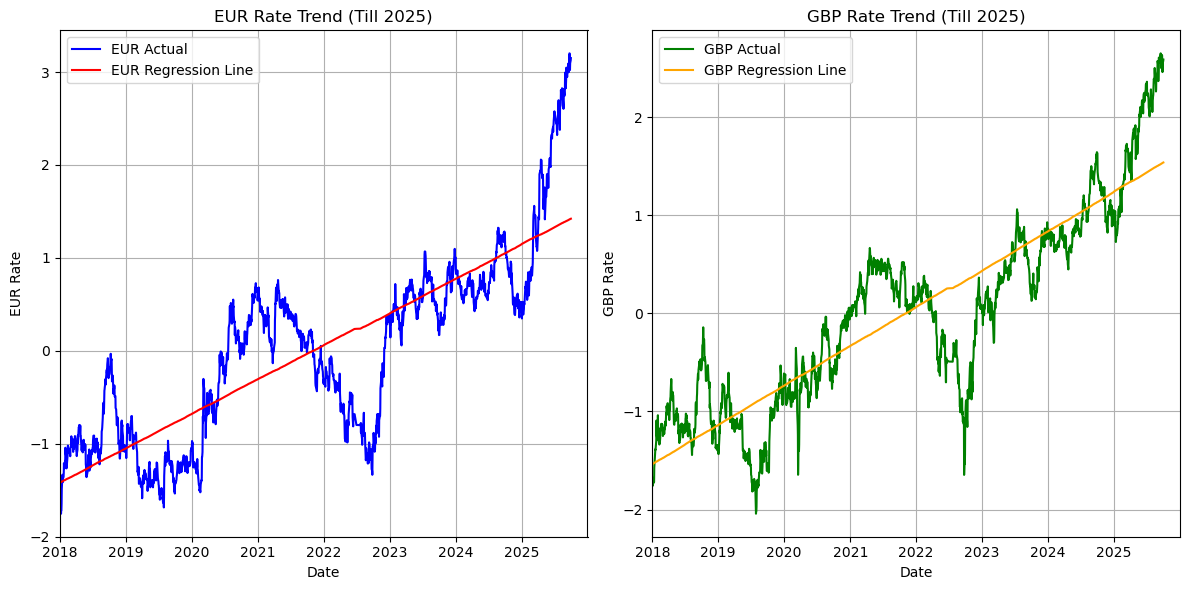

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Convert Date to datetime
dataset['Date'] = pd.to_datetime(dataset['Date'], errors='coerce')

# Filter data only till 2025
data_2025 = dataset[dataset['Date'].dt.year <= 2025]

# ========== EUR Regression ==========
X_eur = data_2025.index.values.reshape(-1, 1)
y_eur = data_2025['EUR_Rate'].values

model_eur = LinearRegression()
model_eur.fit(X_eur, y_eur)
y_pred_eur = model_eur.predict(X_eur)

# ========== GBP Regression ==========
y_gbp = data_2025['GBP_Rate'].values

model_gbp = LinearRegression()
model_gbp.fit(X_eur, y_gbp)
y_pred_gbp = model_gbp.predict(X_eur)

# ========== Plot Both ==========
plt.figure(figsize=(12,6))

# EUR plot
plt.subplot(1, 2, 1)
plt.plot(data_2025['Date'], y_eur, color='blue', label='EUR Actual')
plt.plot(data_2025['Date'], y_pred_eur, color='red', label='EUR Regression Line')
plt.title('EUR Rate Trend (Till 2025)')
plt.xlabel('Date')
plt.ylabel('EUR Rate')
plt.legend()
plt.grid(True)
plt.xlim(pd.Timestamp('2018-01-01'), pd.Timestamp('2025-12-31'))

# GBP plot
plt.subplot(1, 2, 2)
plt.plot(data_2025['Date'], y_gbp, color='green', label='GBP Actual')
plt.plot(data_2025['Date'], y_pred_gbp, color='orange', label='GBP Regression Line')
plt.title('GBP Rate Trend (Till 2025)')
plt.xlabel('Date')
plt.ylabel('GBP Rate')
plt.legend()
plt.grid(True)
plt.xlim(pd.Timestamp('2018-01-01'), pd.Timestamp('2025-12-31'))

plt.tight_layout()
plt.show()


## Test-Test Split

In [28]:
from sklearn.model_selection import train_test_split

# For predicting EUR_Rate
X_eur = dataset[['GBP_Rate', 'GBP_7DMA', 'EUR_7DMA', 'GBP_EUR_Ratio']]
y_eur = dataset['EUR_Rate']

X_train_eur, X_test_eur, y_train_eur, y_test_eur = train_test_split(
    X_eur, y_eur, test_size=0.2, random_state=42
)

print("✅ EUR_Rate Split Completed")
print("Training samples:", len(X_train_eur))
print("Testing samples:", len(X_test_eur))

✅ EUR_Rate Split Completed
Training samples: 1511
Testing samples: 378


In [29]:
X_gbp = dataset[['EUR_Rate', 'GBP_7DMA', 'EUR_7DMA', 'GBP_EUR_Ratio']]
y_gbp = dataset['GBP_Rate']

X_train_gbp, X_test_gbp, y_train_gbp, y_test_gbp = train_test_split(
    X_gbp, y_gbp, test_size=0.2, random_state=42
)

print("✅ GBP_Rate Split Completed")
print("Training samples:", len(X_train_gbp))
print("Testing samples:", len(X_test_gbp))

✅ GBP_Rate Split Completed
Training samples: 1511
Testing samples: 378


In [30]:
linear_model = LinearRegression()
linear_model.fit(X_eur, y_eur) 

LinearRegression()

## Making Predictions

In [31]:
y_test_pred = linear_model.predict(X_eur)

In [32]:
y_test_pred

array([-1.60837292, -1.61846246, -1.66526394, ...,  3.06637554,
        3.0921031 ,  3.11533672])

## Evaluating Euro

In [33]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
r2_eur = r2_score(y_eur, y_pred_eur)
print("R² Score:", round(r2_eur, 4))

R² Score: 0.6744


In [34]:
mae_eur = mean_absolute_error(y_eur, y_pred_eur)
print("Mean Absolute Error:", round(mae_eur, 4))

Mean Absolute Error: 0.4462


In [35]:
rmse_eur = np.sqrt(mean_squared_error(y_eur, y_pred_eur))
print("Root Mean Squared Error:", round(rmse_eur, 4))

Root Mean Squared Error: 0.5706


## Evaluating Pound

In [36]:
r2_gbp = r2_score(y_gbp, y_pred_gbp)
print("R² Score:", round(r2_gbp, 4))

R² Score: 0.7904


In [37]:
mae_gbp = mean_absolute_error(y_gbp, y_pred_gbp)
print("Mean Absolute Error:", round(mae_gbp, 4))

Mean Absolute Error: 0.3508


In [38]:
rmse_gbp = np.sqrt(mean_squared_error(y_gbp, y_pred_gbp))
print("Root Mean Squared Error:", round(rmse_gbp, 4))

Root Mean Squared Error: 0.4579


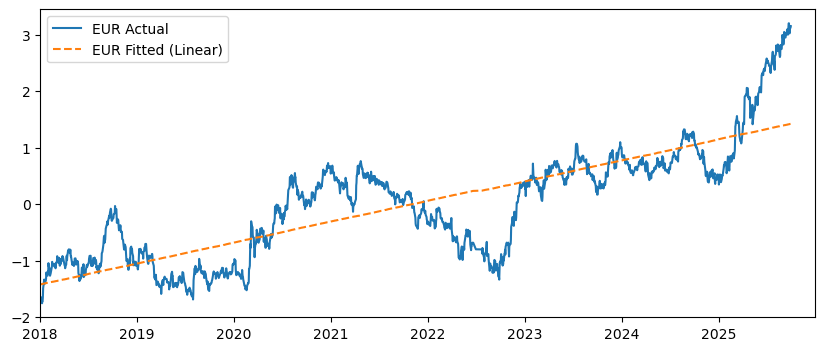

In [39]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.plot(data_2025['Date'], y_eur, label='EUR Actual')
plt.plot(data_2025['Date'], y_pred_eur, label='EUR Fitted (Linear)', linestyle='--')
plt.xlim(pd.Timestamp('2018-01-01'), pd.Timestamp('2025-12-31'))
plt.legend(); plt.show()

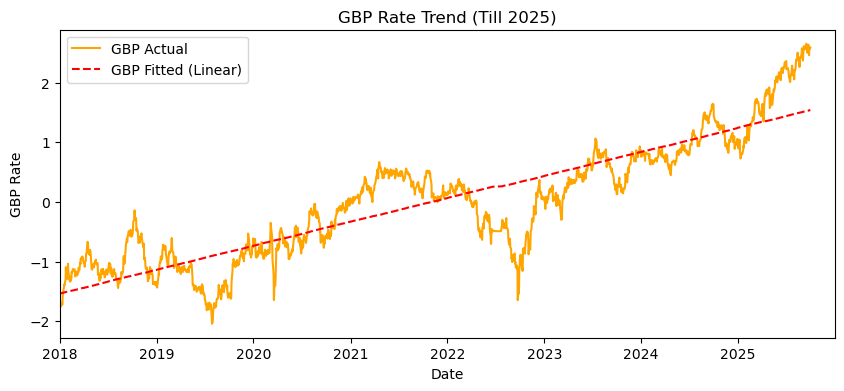

In [40]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.plot(data_2025['Date'], y_gbp, label='GBP Actual', color='orange')
plt.plot(data_2025['Date'], y_pred_gbp, label='GBP Fitted (Linear)', linestyle='--', color='red')
plt.xlim(pd.Timestamp('2018-01-01'), pd.Timestamp('2025-12-31'))
plt.title("GBP Rate Trend (Till 2025)")
plt.xlabel("Date")
plt.ylabel("GBP Rate")
plt.legend()
plt.show()

## Calculating the P-Value for Euro

In [41]:
import statsmodels.api as sm

# Define X and y just like in sklearn
X = dataset[['GBP_Rate', 'GBP_7DMA', 'EUR_7DMA', 'GBP_EUR_Ratio']]
y = dataset['EUR_Rate']

# Add a constant (intercept term)
X = sm.add_constant(X)

# Fit the model
model_eur_stats = sm.OLS(y, X).fit()

# Display the summary table (includes p-values)
print(model_eur_stats.summary())


                            OLS Regression Results                            
Dep. Variable:               EUR_Rate   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.284e+06
Date:                Thu, 30 Oct 2025   Prob (F-statistic):               0.00
Time:                        08:34:51   Log-Likelihood:                 4791.5
No. Observations:                1889   AIC:                            -9573.
Df Residuals:                    1884   BIC:                            -9545.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          6.317e-16      0.000   1.43e-12

## Calculating P-Value for Pound

In [42]:
X = dataset[['EUR_Rate', 'GBP_7DMA', 'EUR_7DMA', 'GBP_EUR_Ratio']]
y = dataset['GBP_Rate']

X = sm.add_constant(X)
model_gbp_stats = sm.OLS(y, X).fit()

print(model_gbp_stats.summary())

                            OLS Regression Results                            
Dep. Variable:               GBP_Rate   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.742e+06
Date:                Thu, 30 Oct 2025   Prob (F-statistic):               0.00
Time:                        08:34:51   Log-Likelihood:                 5079.7
No. Observations:                1889   AIC:                        -1.015e+04
Df Residuals:                    1884   BIC:                        -1.012e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -7.941e-16      0.000   -2.1e-12

## ARIMA For Euro


In [43]:
#Choose how mant days to forecast
H_week = 7
H_month = 30

In [44]:
#Helper to fit ARIMA and return forecasts with date index
from datetime import timedelta
def arima_forecast_dates(series, last_date, order=(1,1,1), steps=7):
    model = ARIMA(series, order=order)
    res = model.fit()
    fc = res.forecast(steps=steps)
    fc_dates = pd.date_range(start=last_date + timedelta(days=1), periods=steps, freq='D')
    return pd.Series(fc.values, index=fc_dates)

In [45]:
eur_series = dataset['EUR_Rate'].astype(float).dropna()
last_date = dataset['Date'].iloc[-1]


In [46]:
eur_fc_week = arima_forecast_dates(eur_series, last_date, order=(1,1,1), steps=H_week)
eur_fc_month = arima_forecast_dates(eur_series, last_date, order=(1,1,1), steps=H_month)

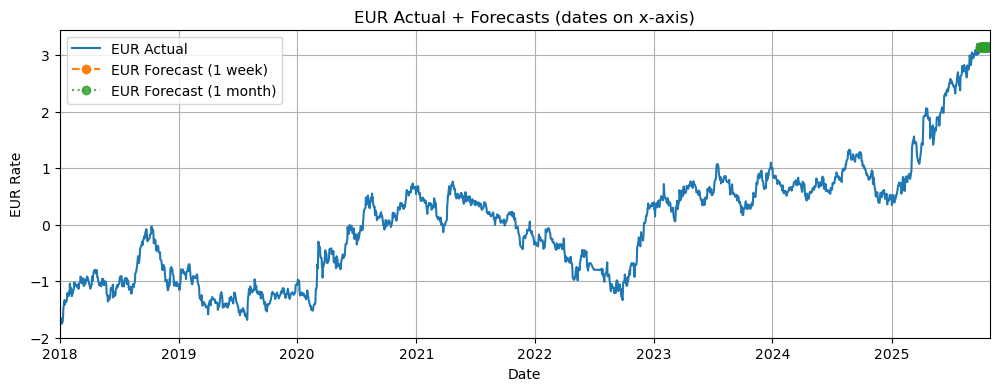

In [47]:
plt.figure(figsize=(12,4))
plt.plot(dataset['Date'], eur_series, label='EUR Actual')
plt.plot(eur_fc_week.index, eur_fc_week.values, '--o', label='EUR Forecast (1 week)')
plt.plot(eur_fc_month.index, eur_fc_month.values, ':o', label='EUR Forecast (1 month)', alpha=0.8)
plt.xlim(dataset['Date'].iloc[0], eur_fc_month.index[-1])          # show up to the last forecast date
plt.title("EUR Actual + Forecasts (dates on x-axis)")
plt.xlabel("Date")
plt.ylabel("EUR Rate")
plt.legend()
plt.grid(True)
plt.show()

## ARIMA For Great Britian Pound

In [48]:
gbp_series = dataset['GBP_Rate'].astype(float).dropna()

gbp_fc_week = arima_forecast_dates(gbp_series, last_date, order=(1,1,1), steps=H_week)
gbp_fc_month = arima_forecast_dates(gbp_series, last_date, order=(1,1,1), steps=H_month)

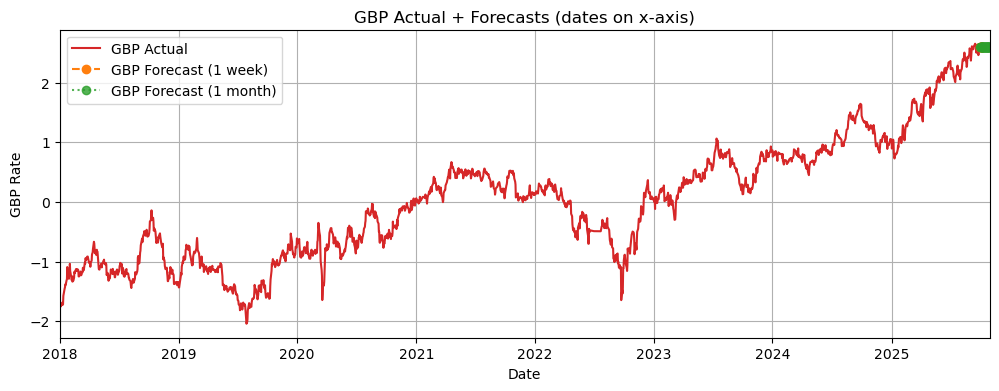

In [49]:
plt.figure(figsize=(12,4))
plt.plot(dataset['Date'], gbp_series, label='GBP Actual', color='C3')
plt.plot(gbp_fc_week.index, gbp_fc_week.values, '--o', label='GBP Forecast (1 week)', color='C1')
plt.plot(gbp_fc_month.index, gbp_fc_month.values, ':o', label='GBP Forecast (1 month)', color='C2', alpha=0.8)
plt.xlim(dataset['Date'].iloc[0], gbp_fc_month.index[-1])
plt.title("GBP Actual + Forecasts (dates on x-axis)")
plt.xlabel("Date")
plt.ylabel("GBP Rate")
plt.legend()
plt.grid(True)
plt.show()

In [50]:
#Printing numeric forecasts
print("EUR 7-day:\n", eur_fc_week)
print("\nEUR 30-day (first 10 shown):\n", eur_fc_month.head(10))
print("\nGBP 7-day:\n", gbp_fc_week)
print("\nGBP 30-day (first 10 shown):\n", gbp_fc_month.head(10))

EUR 7-day:
 2025-10-01    3.151870
2025-10-02    3.151344
2025-10-03    3.151580
2025-10-04    3.151474
2025-10-05    3.151521
2025-10-06    3.151500
2025-10-07    3.151509
Freq: D, dtype: float64

EUR 30-day (first 10 shown):
 2025-10-01    3.151870
2025-10-02    3.151344
2025-10-03    3.151580
2025-10-04    3.151474
2025-10-05    3.151521
2025-10-06    3.151500
2025-10-07    3.151509
2025-10-08    3.151505
2025-10-09    3.151507
2025-10-10    3.151506
Freq: D, dtype: float64

GBP 7-day:
 2025-10-01    2.588957
2025-10-02    2.589032
2025-10-03    2.589041
2025-10-04    2.589042
2025-10-05    2.589042
2025-10-06    2.589042
2025-10-07    2.589042
Freq: D, dtype: float64

GBP 30-day (first 10 shown):
 2025-10-01    2.588957
2025-10-02    2.589032
2025-10-03    2.589041
2025-10-04    2.589042
2025-10-05    2.589042
2025-10-06    2.589042
2025-10-07    2.589042
2025-10-08    2.589042
2025-10-09    2.589042
2025-10-10    2.589042
Freq: D, dtype: float64


## Evaluation of ARIMA for Euro

In [51]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

In [52]:
# Fit ARIMA model for EUR
from statsmodels.tsa.arima.model import ARIMA

In [53]:
# Assuming your column is named 'EUR_Rate'
eur_data = dataset['EUR_Rate']

In [54]:
# Split data into train and test
train_size = int(len(eur_data) * 0.8)
train, test = eur_data[:train_size], eur_data[train_size:]

In [55]:
# Fit ARIMA model
model = ARIMA(train, order=(1, 1, 1))
model_fit = model.fit()

In [56]:
# Make predictions
predictions = model_fit.forecast(steps=len(test))

In [57]:
# Evaluate model
mse = mean_squared_error(test, predictions)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test, predictions)
mape = np.mean(np.abs((test - predictions) / test)) * 100

print("ARIMA Evaluation for Euro:")
print("Mean Squared Error (MSE):", round(mse, 4))
print("Root Mean Squared Error (RMSE):", round(rmse, 4))
print("Mean Absolute Error (MAE):", round(mae, 4))
print("Mean Absolute Percentage Error (MAPE):", round(mape, 2), "%")

ARIMA Evaluation for Euro:
Mean Squared Error (MSE): 0.8766
Root Mean Squared Error (RMSE): 0.9363
Mean Absolute Error (MAE): 0.6469
Mean Absolute Percentage Error (MAPE): 42.67 %


## Evaluation of ARIMA for Pound

In [58]:
gbp_data = dataset['GBP_Rate']

In [59]:
# Split 80% train, 20% test
train_size_gbp = int(len(gbp_data) * 0.8)
train_gbp, test_gbp = gbp_data[:train_size_gbp], gbp_data[train_size_gbp:]

In [60]:
# Fit ARIMA model
model_gbp = ARIMA(train_gbp, order=(1, 1, 1))
model_fit_gbp = model_gbp.fit()

In [61]:
# Forecast
predictions_gbp = model_fit_gbp.forecast(steps=len(test_gbp))


In [62]:
# Evaluate
mse_gbp = mean_squared_error(test_gbp, predictions_gbp)
rmse_gbp = np.sqrt(mse_gbp)
mae_gbp = mean_absolute_error(test_gbp, predictions_gbp)
mape_gbp = np.mean(np.abs((test_gbp - predictions_gbp) / test_gbp)) * 100

print("💷 ARIMA Evaluation for GBP:")
print("MSE:", round(mse_gbp, 4))
print("RMSE:", round(rmse_gbp, 4))
print("MAE:", round(mae_gbp, 4))
print("MAPE:", round(mape_gbp, 2), "%")


💷 ARIMA Evaluation for GBP:
MSE: 0.62
RMSE: 0.7874
MAE: 0.5885
MAPE: 34.23 %


## LSTM For Euro

In [63]:
#Select only EUR column
eur_data = dataset[['EUR_Rate']].values


In [64]:
#Normalize the data between 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))
eur_scaled = scaler.fit_transform(eur_data)

In [65]:
#Create training sequences
X, y = [], []
for i in range(60, len(eur_scaled)):
    X.append(eur_scaled[i-60:i, 0])  # last 60 days
    y.append(eur_scaled[i, 0])

In [66]:
X, y = np.array(X), np.array(y)
X = np.reshape(X, (X.shape[0], X.shape[1], 1))  # reshape for LSTM

In [67]:
#Build LSTM Model
model = Sequential()
model.add(LSTM(units=50, return_sequences=False, input_shape=(X.shape[1], 1)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

C:\Users\shahj\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [68]:
model.fit(X, y, epochs=350, batch_size=32, verbose=1)

Epoch 1/350
58/58 ━━━━━━━━━━━━━━━━━━━━ 6s 32ms/step - loss: 0.0134
Epoch 2/350
58/58 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 8.5280e-04 
Epoch 3/350
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 7.8859e-04
Epoch 4/350
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 7.6526e-04
Epoch 5/350
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 7.1775e-04
Epoch 6/350
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 7.0709e-04
Epoch 7/350
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 6.5567e-04
Epoch 8/350
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 6.3827e-04
Epoch 9/350
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 6.1081e-04
Epoch 10/350
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 6.1256e-04
Epoch 11/350
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 5.6561e-04
Epoch 12/350
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 5.4341e-04
Epoch 13/350
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 5.5419e-04
Epoch 14/350
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 5.0759e-04
Epoc

In [69]:
last_60_days = eur_scaled[-60:]
predictions = []
current_input = last_60_days.copy()


In [70]:
for _ in range(30):  # Forecast 1 month (30 days)
    pred = model.predict(current_input.reshape(1, 60, 1))
    predictions.append(pred[0, 0])
    current_input = np.append(current_input[1:], pred, axis=0)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━

In [71]:
predicted_values = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

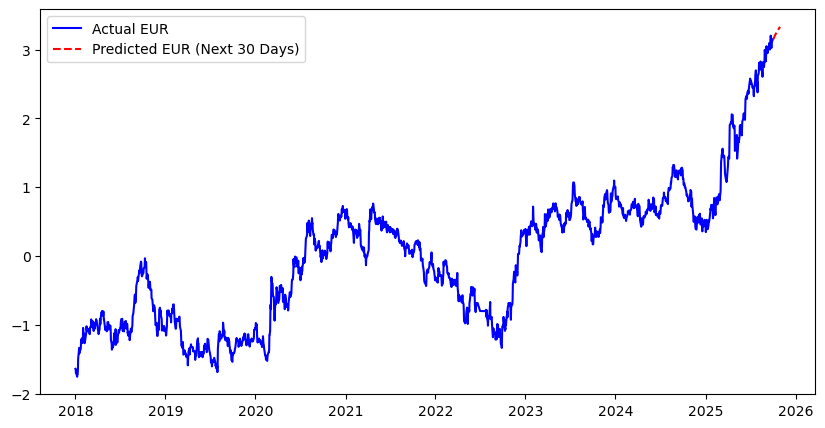

In [72]:
plt.figure(figsize=(10,5))
plt.plot(dataset['Date'], dataset['EUR_Rate'], label='Actual EUR', color='blue')
future_dates = pd.date_range(start=dataset['Date'].iloc[-1], periods=31, freq='D')[1:]
plt.plot(future_dates, predicted_values, label='Predicted EUR (Next 30 Days)', color='red', linestyle='--')
plt.legend()
plt.show()

## LSTM For GBP

In [73]:
#Use only GBP rate
gbp = dataset[['GBP_Rate']].dropna().astype(float)

In [74]:
#Scale the values
scaler = MinMaxScaler(feature_range=(0, 1))
gbp_scaled = scaler.fit_transform(gbp.values)

In [75]:
#Create sequences
TIME_STEP = 60   # use past 60 days
X, y = [], []
for i in range(TIME_STEP, len(gbp_scaled)):
    X.append(gbp_scaled[i-TIME_STEP:i, 0])    # sequence of length TIME_STEP
    y.append(gbp_scaled[i, 0])               # next day value

X = np.array(X)            # (samples, TIME_STEP)
y = np.array(y)            # (samples,)
X = X.reshape((X.shape[0], X.shape[1], 1)) 

In [76]:
#Build LSTM Model
model = Sequential([
    LSTM(50, input_shape=(TIME_STEP, 1)),
    Dense(1)
])
model.compile(optimizer='adam', loss='mse')

C:\Users\shahj\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [77]:
#Train the model
model.fit(X, y, epochs=350, batch_size=16, verbose=1)

Epoch 1/350
115/115 ━━━━━━━━━━━━━━━━━━━━ 6s 21ms/step - loss: 0.0133
Epoch 2/350
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 9.2631e-04
Epoch 3/350
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 9.2006e-04
Epoch 4/350
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 8.5547e-04
Epoch 5/350
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 8.3019e-04
Epoch 6/350
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 7.6079e-04
Epoch 7/350
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 7.6105e-04
Epoch 8/350
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 7.0510e-04
Epoch 9/350
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 6.7676e-04
Epoch 10/350
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 6.5566e-04
Epoch 11/350
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 6.1821e-04
Epoch 12/350
115/115 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 6.2602e-04
Epoch 13/350
115/115 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 5.7301e-04
Epoch 14/350
115/115 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/s

In [78]:
#Forecast next 30 days
FORECAST_DAYS = 30
last_window = gbp_scaled[-TIME_STEP:].copy()      # shape (TIME_STEP, 1)
preds_scaled = []

for _ in range(FORECAST_DAYS):
    x_input = last_window.reshape((1, TIME_STEP, 1))      # (1, TIME_STEP, 1)
    yhat = model.predict(x_input, verbose=0)             # shape (1,1)
    preds_scaled.append(yhat[0,0])
    # append predicted value to last_window and drop oldest
    new_row = np.array([[yhat[0,0]]])                    # shape (1,1)
    last_window = np.vstack((last_window[1:], new_row))  # keep shape (TIME_STEP,1)


In [79]:
#Inverse scale to original units
preds = scaler.inverse_transform(np.array(preds_scaled).reshape(-1,1)).flatten()

In [80]:
#Build forecast dataframe and plot
future_dates = pd.date_range(start=dataset['Date'].iloc[-1] + pd.Timedelta(days=1),
                             periods=FORECAST_DAYS, freq='D')
forecast_df = pd.DataFrame({'Date': future_dates, 'GBP_Forecast': preds})


In [81]:
#Print numeric forecasts
print(forecast_df)


         Date  GBP_Forecast
0  2025-10-01      2.552688
1  2025-10-02      2.524677
2  2025-10-03      2.509249
3  2025-10-04      2.498919
4  2025-10-05      2.486535
5  2025-10-06      2.470767
6  2025-10-07      2.453096
7  2025-10-08      2.435155
8  2025-10-09      2.417612
9  2025-10-10      2.400302
10 2025-10-11      2.382840
11 2025-10-12      2.365003
12 2025-10-13      2.346797
13 2025-10-14      2.328332
14 2025-10-15      2.309716
15 2025-10-16      2.291006
16 2025-10-17      2.272219
17 2025-10-18      2.253367
18 2025-10-19      2.234485
19 2025-10-20      2.215657
20 2025-10-21      2.196942
21 2025-10-22      2.178370
22 2025-10-23      2.159950
23 2025-10-24      2.141665
24 2025-10-25      2.123473
25 2025-10-26      2.105304
26 2025-10-27      2.087079
27 2025-10-28      2.068702
28 2025-10-29      2.050092
29 2025-10-30      2.031227


C:\Users\shahj\AppData\Local\Temp\ipykernel_4356\1565970266.py:4: UserWarning: linestyle is redundantly defined by the 'linestyle' keyword argument and the fmt string "--o" (-> linestyle='--'). The keyword argument will take precedence.
  plt.plot(forecast_df['Date'], forecast_df['GBP_Forecast'], '--o', label='GBP Forecast (31 days)', color='tab:orange',linestyle='--')


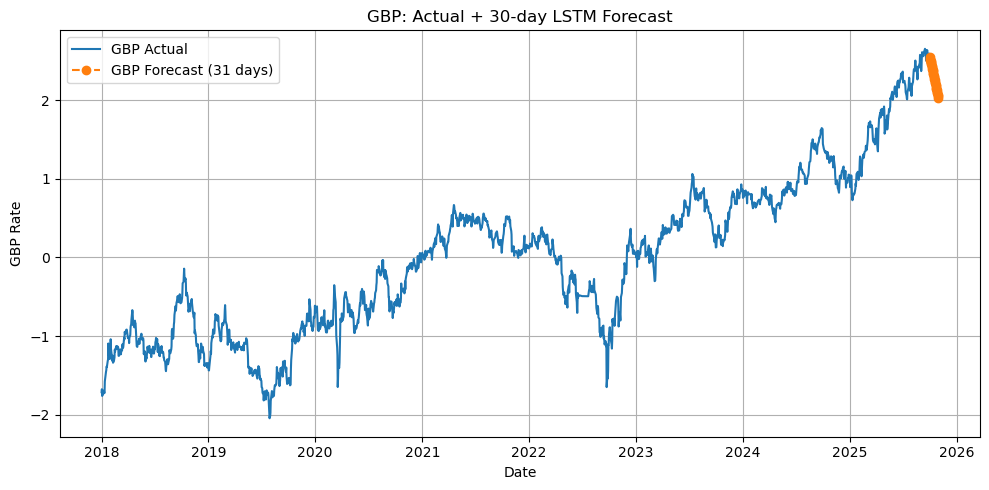

In [82]:
#PLot actual and forecast
plt.figure(figsize=(10,5))
plt.plot(dataset['Date'], dataset['GBP_Rate'], label='GBP Actual', color='tab:blue')
plt.plot(forecast_df['Date'], forecast_df['GBP_Forecast'], '--o', label='GBP Forecast (31 days)', color='tab:orange',linestyle='--')
plt.xlabel('Date'); plt.ylabel('GBP Rate')
plt.title('GBP: Actual + 30-day LSTM Forecast')
plt.legend(); plt.grid(True); plt.tight_layout()
plt.show()

## Evaluation of Euro LSTM Model

In [83]:
# Split data into training and testing
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [84]:
# Reshape for LSTM input (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [85]:
#Make predictions on the test data
y_pred = model.predict(X_test)

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step 


In [86]:
#Reverse scaling to get actual price values
y_pred_inv = scaler.inverse_transform(y_pred.reshape(-1, 1))
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

In [87]:
#Calculate evaluation metrics
mse = mean_squared_error(y_test_inv, y_pred_inv)
mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_inv, y_pred_inv)

print("📊 LSTM Evaluation Results for EURO:")
print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("Root Mean Squared Error (RMSE):", rmse)
print("R² Score:", r2)

📊 LSTM Evaluation Results for EURO:
Mean Squared Error (MSE): 0.004630310397094382
Mean Absolute Error (MAE): 0.05418373369400863
Root Mean Squared Error (RMSE): 0.06804638415885433
R² Score: 0.986139933701051


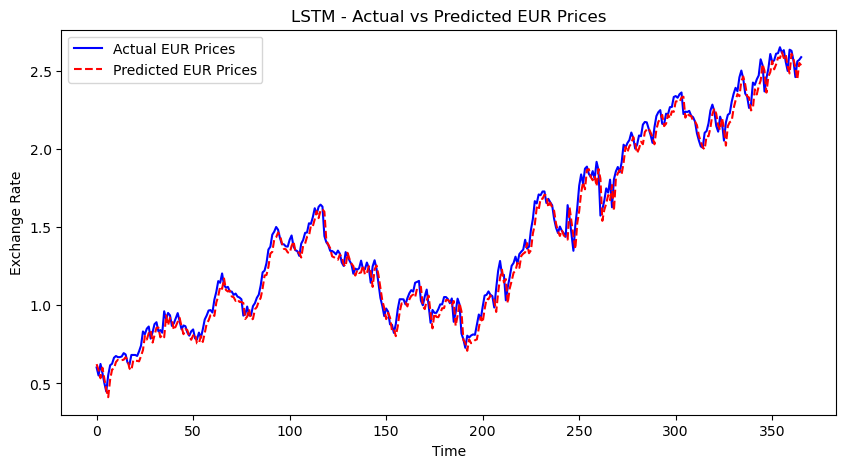

In [88]:
#Plot
plt.figure(figsize=(10,5))
plt.plot(y_test_inv, label='Actual EUR Prices', color='blue')
plt.plot(y_pred_inv, label='Predicted EUR Prices', color='red', linestyle='--')
plt.title('LSTM - Actual vs Predicted EUR Prices')
plt.xlabel('Time')
plt.ylabel('Exchange Rate')
plt.legend()
plt.show()


## Evaluation of GBP LSTM Model

In [89]:
mae = mean_absolute_error(y_test_inv, y_pred_inv)
mse = mean_squared_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_inv, y_pred_inv)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"R² Score: {r2:.4f}")

Mean Absolute Error (MAE): 0.0542
Mean Squared Error (MSE): 0.0046
Root Mean Squared Error (RMSE): 0.0680
R² Score: 0.9861


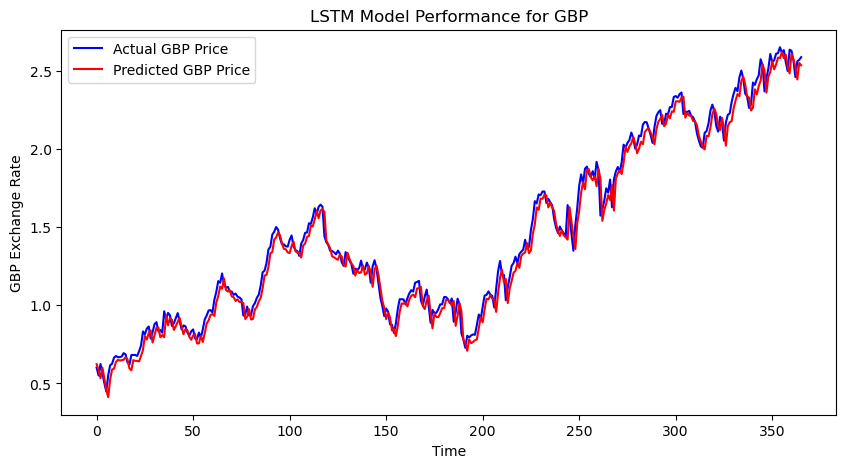

In [90]:
plt.figure(figsize=(10,5))
plt.plot(y_test_inv, label='Actual GBP Price', color='blue')
plt.plot(y_pred_inv, label='Predicted GBP Price', color='red')
plt.title('LSTM Model Performance for GBP')
plt.xlabel('Time')
plt.ylabel('GBP Exchange Rate')
plt.legend()
plt.show()